## **Dual Listing Arbitrage**

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Dec 21 12:13:00 2022

@author: Bradley

Sample code for dual listing arbitrage
"""

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from datetime import datetime
from functools import partial
import os

import warnings
warnings.filterwarnings('ignore') 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
pd.set_option('expand_frame_repr', True) 
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.width', 180) #
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline


A Project to identify arbitrage opportunities between two stock exchanges trading the same stock. The algorithm searches for the possibility of a mismatch and trades on it. Next to that, it takes into account certain limits, which is set to a max position of 250 to prevent massive losses if the algorithm malfunctions.

In [5]:
market_data = pd.read_csv("./data/HWG.csv", index_col=[0])
market_data.index.name = 'time'
market_data.columns = [market_data.columns.str[-7:], market_data.columns.str[:-8]]
market_data

I-XCHNG                               Z-XCHNG                             
                    BidPrice BidVolume AskPrice AskVolume BidPrice BidVolume AskPrice AskVolume
time                                                                                           
2018-01-01 00:05:00   114.25     120.0   114.55     120.0   113.95      40.0   114.85      40.0
2018-01-01 00:10:00   114.05     119.0   114.40     102.0   113.65      42.0   114.60      36.0
2018-01-01 00:15:00   114.05     119.0   114.40     105.0   113.30      41.0   114.35      35.0
2018-01-01 00:20:00   114.00     116.0   114.40     124.0   113.50      40.0   114.55      37.0
2018-01-01 00:25:00   114.00     118.0   114.35     133.0   113.45      43.0   114.40      33.0
...                      ...       ...      ...       ...      ...       ...      ...       ...
2018-02-28 23:35:00   120.35     123.0   120.65     115.0   119.80      31.0   120.65      44.0
2018-02-28 23:40:00   120.30     119.0   120.65     110.0   119.80      34.0   120.65      44.0
2018-02-28 23:45:00   120.40     112.0   120.70     108.0   119.60      31.0   120.40      42.0
2018-02-28 23:50:00   120.30     111.0   120.60     104.0   119.55      33.0   120.35      38.0
2018-02-28 23:55:00   120.35     111.0   120.65     112.0   119.70      34.0   120.50      40.0

[16991 rows x 8 columns]

<Figure size 1008x288 with 0 Axes>

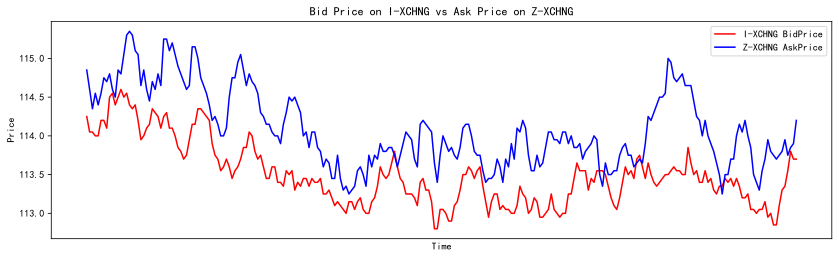

In [9]:
# Select the first 250 rows
market_data_250 = market_data.iloc[:250]

# Set figsize of plot
plt.figure(figsize=(14, 4))

# Create a plot showing the bid and ask prices on different exchanges
def Plot_Bid_Ask(stock1 = 'I-XCHNG', stock2 = 'Z-XCHNG'):
    plt.plot(market_data_250.index, market_data_250[stock1, 'BidPrice'], color='r')
    plt.plot(market_data_250.index, market_data_250[stock2, 'AskPrice'], color='b')
    plt.xticks([])
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('Bid Price on '  + stock1 + ' vs Ask Price on ' + stock2)
    plt.legend([stock1 + ' BidPrice', stock2 + ' AskPrice'])
    plt.show()


# Note arbitrage possible in case the BidPrice is higher than the AskPrice.
Plot_Bid_Ask()

In [11]:
# calculate price differences
market_data['I-Bid-Z-Ask-Spread'] = market_data['I-XCHNG', 'BidPrice'] - market_data['Z-XCHNG', 'AskPrice']
market_data['Z-Bid-I-Ask-Spread'] = market_data['Z-XCHNG', 'BidPrice'] - market_data['I-XCHNG', 'AskPrice']
market_data

I-XCHNG                               Z-XCHNG                              I-Bid-Z-Ask-Spread Z-Bid-I-Ask-Spread
                    BidPrice BidVolume AskPrice AskVolume BidPrice BidVolume AskPrice AskVolume                                      
time                                                                                                                                 
2018-01-01 00:05:00   114.25     120.0   114.55     120.0   113.95      40.0   114.85      40.0              -0.60              -0.60
2018-01-01 00:10:00   114.05     119.0   114.40     102.0   113.65      42.0   114.60      36.0              -0.55              -0.75
2018-01-01 00:15:00   114.05     119.0   114.40     105.0   113.30      41.0   114.35      35.0              -0.30              -1.10
2018-01-01 00:20:00   114.00     116.0   114.40     124.0   113.50      40.0   114.55      37.0              -0.55              -0.90
2018-01-01 00:25:00   114.00     118.0   114.35     133.0   113.45      43.0   114.40      33.0              -0.40              -0.90
...                      ...       ...      ...       ...      ...       ...      ...       ...                ...                ...
2018-02-28 23:35:00   120.35     123.0   120.65     115.0   119.80      31.0   120.65      44.0              -0.30              -0.85
2018-02-28 23:40:00   120.30     119.0   120.65     110.0   119.80      34.0   120.65      44.0              -0.35              -0.85
2018-02-28 23:45:00   120.40     112.0   120.70     108.0   119.60      31.0   120.40      42.0               0.00              -1.10
2018-02-28 23:50:00   120.30     111.0   120.60     104.0   119.55      33.0   120.35      38.0              -0.05              -1.05
2018-02-28 23:55:00   120.35     111.0   120.65     112.0   119.70      34.0   120.50      40.0              -0.15              -0.95

[16991 rows x 10 columns]

In [16]:
# risk-free arbitrage opportunities
arbitrage = market_data.loc[(market_data['I-Bid-Z-Ask-Spread'] > 0) | (market_data['Z-Bid-I-Ask-Spread'] > 0)]
arbitrage

I-XCHNG                               Z-XCHNG                              I-Bid-Z-Ask-Spread Z-Bid-I-Ask-Spread
                    BidPrice BidVolume AskPrice AskVolume BidPrice BidVolume AskPrice AskVolume                                      
time                                                                                                                                 
2018-01-01 04:30:00   113.60     119.0   113.90      98.0   114.05      34.0   114.95      39.0              -1.35               0.15
2018-01-01 04:35:00   113.70     108.0   114.00     103.0   114.20      33.0   115.05      35.0              -1.35               0.20
2018-01-01 09:05:00   113.80      88.0   114.10      88.0   112.90      24.0   113.75      31.0               0.05              -1.20
2018-01-01 15:05:00   113.55     130.0   113.85     112.0   112.70      37.0   113.50      39.0               0.05              -1.15
2018-01-01 15:10:00   113.55     129.0   113.85     113.0   112.55      38.0   113.35      39.0               0.20              -1.30
...                      ...       ...      ...       ...      ...       ...      ...       ...                ...                ...
2018-02-28 17:20:00   120.95      93.0   121.30     118.0   121.45      29.0   122.40      32.0              -1.45               0.15
2018-02-28 17:25:00   120.90      86.0   121.20     113.0   121.30      26.0   122.20      28.0              -1.30               0.10
2018-02-28 19:30:00   120.85     112.0   121.15     126.0   120.00      38.0   120.80      43.0               0.05              -1.15
2018-02-28 19:35:00   120.85     116.0   121.15     119.0   119.90      40.0   120.80      42.0               0.05              -1.25
2018-02-28 23:15:00   120.20     104.0   120.45     108.0   120.60      34.0   121.25      29.0              -1.05               0.15

[561 rows x 10 columns]

In [15]:
for time, m in market_data.iterrows():
    print(time)
    print(m)
    break

2018-01-01 00:05:00
I-XCHNG             BidPrice     114.25
                    BidVolume    120.00
                    AskPrice     114.55
                    AskVolume    120.00
Z-XCHNG             BidPrice     113.95
                    BidVolume     40.00
                    AskPrice     114.85
                    AskVolume     40.00
I-Bid-Z-Ask-Spread                -0.60
Z-Bid-I-Ask-Spread                -0.60
Name: 2018-01-01 00:05:00, dtype: float64


In [13]:
# Design arbitrage strategy that gives all positions

positions = {'Timestamp': [],
             'Position-I-XCHNG': [],
             'Position-Z-XCHNG': []}

current_position = 0

for time, tick_data in market_data.iterrows():

    if tick_data['I-Bid-Z-Ask-Spread', ''] > 0:
        buy = min(tick_data['I-XCHNG', 'BidVolume'],
                  tick_data['Z-XCHNG', 'AskVolume'], (250 - current_position))
        spread = tick_data['I-Bid-Z-Ask-Spread']
        positions['Timestamp'].append(time)
        positions['Position-I-XCHNG'].append(- buy - current_position)
        positions['Position-Z-XCHNG'].append(+ buy + current_position)
        current_position = buy

    elif tick_data['Z-Bid-I-Ask-Spread', ''] > 0:
        buy = min(tick_data['Z-XCHNG', 'BidVolume'],
                  tick_data['I-XCHNG', 'AskVolume'], (250 - current_position))
        spread = tick_data['Z-Bid-I-Ask-Spread']
        positions['Timestamp'].append(time)
        positions['Position-I-XCHNG'].append(+ buy + current_position)
        positions['Position-Z-XCHNG'].append(- buy - current_position)
        current_position = buy

positions = pd.DataFrame(positions).set_index('Timestamp')

positions

,Position-I-XCHNG,Position-Z-XCHNG
Timestamp,,
2018-01-01 04:30:00,34.0,-34.0
2018-01-01 04:35:00,67.0,-67.0
2018-01-01 09:05:00,-64.0,64.0
2018-01-01 15:05:00,-70.0,70.0
2018-01-01 15:10:00,-78.0,78.0
...,...,...
2018-02-28 17:20:00,59.0,-59.0
2018-02-28 17:25:00,55.0,-55.0
2018-02-28 19:30:00,-69.0,69.0
